In [1]:
correct = False
while not correct:
    %pip install -U implicit
    import pandas as pd
    import numpy as np
    from scipy.sparse import coo_matrix
    from implicit.als import AlternatingLeastSquares
    from implicit.evaluation import mean_average_precision_at_k
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    correct = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: implicit
    Found existing installation: implicit 0.4.4
    Uninstalling implicit-0.4.4:
      Successfully uninstalled implicit-0.4.4
Note: you may need to restart the kernel to use updated packages.


In [2]:
PATH = "../input/h-and-m-personalized-fashion-recommendations/"
articles = pd.read_csv(f"{PATH}articles.csv", encoding="utf-8", dtype={'article_id': str})
customers = pd.read_csv(f"{PATH}customers.csv", encoding="utf-8")
tx = pd.read_csv(f"{PATH}transactions_train.csv", encoding="utf-8", dtype={'article_id': str}, parse_dates=['t_dat'])

In [3]:
USERS = customers.customer_id.unique().tolist()
ITEMS = articles.article_id.unique().tolist()

USER_IDS = dict(list(enumerate(USERS)))
ITEM_IDS = dict(list(enumerate(ITEMS)))

USER_MAP = {u: uidx for uidx, u in USER_IDS.items()}
ITEM_MAP = {i: iidx for iidx, i in ITEM_IDS.items()}

tx['user_id'] = tx['customer_id'].map(USER_MAP)
tx['item_id'] = tx['article_id'].map(ITEM_MAP)

In [4]:
def pd_to_coo_matrix(df):
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(USERS), len(ITEMS)))
    return coo

def train_val_split(df, days=7):
    validation_cut = df['t_dat'].max() - pd.Timedelta(days)

    df_train = df[df['t_dat'] < validation_cut]
    df_val = df[df['t_dat'] >= validation_cut]
    return df_train, df_val

def matrix_maker(df, days=7):
    df_train, df_val = train_val_split(df, days=days)
    coo_train = pd_to_coo_matrix(df_train)
    coo_val = pd_to_coo_matrix(df_val)

    csr_train = coo_train.tocsr()
    csr_val = coo_val.tocsr()
    
    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_val': csr_val}

def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    coo_train = matrices['coo_train']
    csr_train = matrices['csr_train']
    csr_val = matrices['csr_val']
    
    model = AlternatingLeastSquares(
        factors=factors,
        iterations=iterations, 
        regularization=regularization, 
        use_gpu=True,
        random_state=12345)
        
    model.fit(coo_train, show_progress=show_progress)
    
    map12 = mean_average_precision_at_k(model, csr_train, csr_val, K=12, show_progress=show_progress)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [5]:
matrices = matrix_maker(tx)

In [6]:
"""
Best parameters are:

    factors: 60
    iterations: 12
    regularitazion: 0.01

The time needed in order to find the best parameters is:

    CPU times: user 42min 22s, 
    sys: 11.4 s, total: 42min 34s
    Wall time: 42min 43s

Since ALS allows a random state parameter, this cell will be skipped
"""

best_params = {'factors': 60, 'iterations': 12, 'regularization': 0.01}

if not best_params:
    %%time
    best_map12 = 0
    for factors in [40, 50, 60, 100, 200, 500, 1000]:
        for iterations in [3, 12, 14, 15, 20]:
            for regularization in [0.01]:
                map12 = validate(matrices, factors, iterations, regularization, show_progress=False)
                if map12 > best_map12:
                    best_map12 = map12
                    best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                    print(f"Best MAP@12 found. Updating: {best_params}")

In [7]:
coo_train = pd_to_coo_matrix(tx)
csr_train = coo_train.tocsr()

In [8]:
def train(coo_train, factors, iterations, regularization, show_progress=True):
    model = AlternatingLeastSquares(
        factors=factors, 
        iterations=iterations, 
        regularization=regularization,
        use_gpu=True,
        random_state=12345)
        
    model.fit(coo_train, show_progress=show_progress)
    return model

In [9]:
model = train(coo_train, **best_params)

/opt/conda/lib/python3.7/site-packages/implicit/utils.py:141: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 1.7871756553649902 seconds
  ParameterWarning,


  0%|          | 0/12 [00:00<?, ?it/s]

In [10]:
def submit(model, csr_train, submission_name="submissions.csv"):
    preds = []
    batch_size = 2000
    to_generate = np.arange(len(USERS)/10)
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx : startidx + batch_size]
        ids, scores = model.recommend(batch, csr_train[batch], N=12, filter_already_liked_items=True)
        for i, userid in enumerate(batch):
            customer_id = USER_IDS[userid]
            user_items = ids[i]
            article_ids = [ITEM_IDS[item_id] for item_id in user_items]
            preds.append((customer_id, ' '.join(article_ids), scores[i]))

    df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction', 'scores'])
    df_preds.to_csv(submission_name, index=False)
    
    display(df_preds.head())
    print(df_preds.shape)
    
    return df_preds

In [11]:
%%time
df_preds = submit(model, csr_train)

,customer_id,prediction,scores
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568597006 0568601007 0568597007 0507909001 05...,"[0.36251688, 0.1769063, 0.13380231, 0.07145223..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0699080001 0776237020 0599580052 0590928001 07...,"[0.5081311, 0.40864497, 0.37911147, 0.3417227,..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0699080001 0699081001 0609719001 0458543001 08...,"[0.3756321, 0.23122798, 0.18715963, 0.17983729..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0484398001 0720125001 0564786001 0730683001 06...,"[0.021951616, 0.014043135, 0.013484602, 0.0128..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0678942001 0589599047 0727029001 0720125001 06...,"[0.024852341, 0.021156738, 0.02087951, 0.02016..."


(137198, 3)
CPU times: user 24.6 s, sys: 132 ms, total: 24.7 s
Wall time: 24.7 s


In [12]:
"""
Let's check what our recommendations are for first customer.

First we will take the customer_id and then acquire what he has bought in the past
"""
def customer_bought_suggested(ID: int):
    customer_ID = df_preds.customer_id[ID]
    items_bought = tx.loc[tx['customer_id'] == customer_ID].article_id.unique().tolist()
    items_suggested = df_preds.prediction[ID].split()
    scores = df_preds.scores[ID]
    return customer_ID, items_bought, items_suggested, scores

def bought_suggest(ID, rows=2, columns=12, figsize=(20,10)):
    customer_ID, items_bought, items_suggested, scores = customer_bought_suggested(ID)

    f, ax = plt.subplots(rows, columns, figsize=figsize)
    for i in range(rows):
        index = 0
        for j in range(columns):
            if i==0:
                try:
                    img = mpimg.imread(f'{PATH}images/{str(items_bought[index])[:3]}/0{int(items_bought[index])}.jpg')
                    ax[i,j].imshow(img)
                    ax[i,j].set_xticks([], [])
                    ax[i,j].set_yticks([], [])
                    ax[i,j].grid(False)
                    ax[i,j].set_title("Bought")
                    index += 1
                except IndexError:
                    continue
            else:
                try:
                    img = mpimg.imread(f'{PATH}images/{str(items_suggested[index])[:3]}/0{int(items_suggested[index])}.jpg')
                    ax[i,j].imshow(img)
                    ax[i,j].set_xticks([], [])
                    ax[i,j].set_yticks([], [])
                    ax[i,j].grid(False)
                    ax[i,j].set_title("Suggested")
                    ax[i,j].set(xlabel=f'Score: {scores[index]:.4f}')
                    index += 1
                except IndexError:
                    continue
                        
    #plt.suptitle("Item bought in the past")
    plt.tight_layout()
    plt.show()

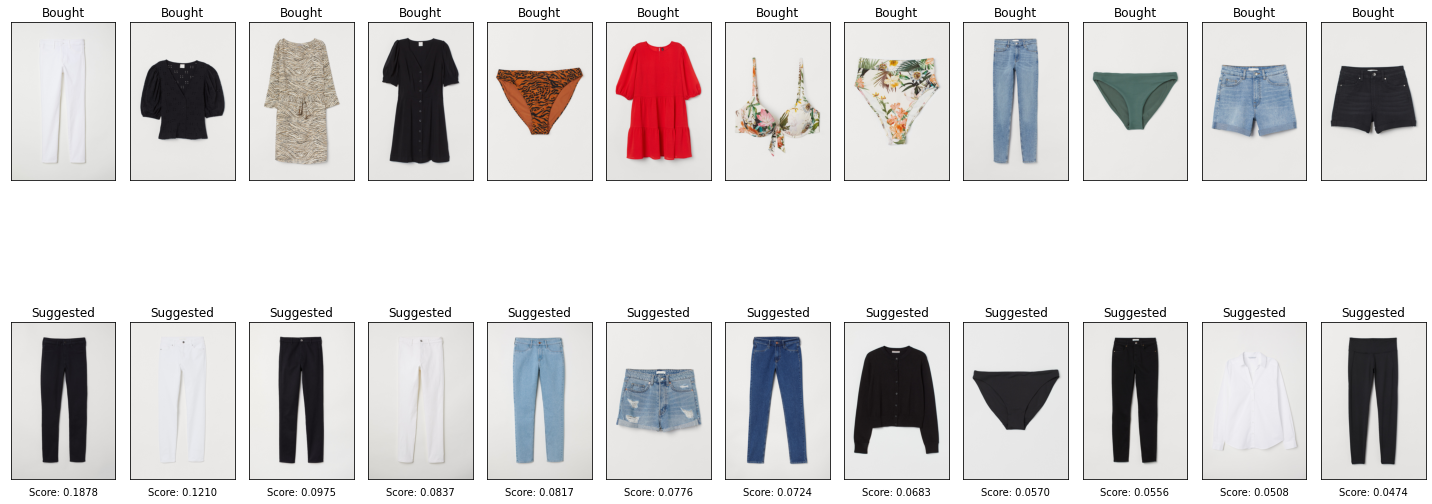

In [13]:
"""
Starting from the products purchased in the past, the model suggests 10 items sorted by decreasing score (where the first is the most recommended)
"""
bought_suggest(ID=1024)